In [1]:
import sys
import os
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src/violin/')))

In [2]:
model_file = 'input/models/SkMel133_biorecipe.xlsx'
reading_file = 'input/interactions/example/RA2_reading_BioRECIPE.xlsx'
out_file = 'output/example/RA2'

In [3]:
###Preamble###
%load_ext autoreload
%autoreload 2

from in_out import preprocessing_model,preprocessing_reading,output
from scoring import score_reading
from network import node_edge_list
from visualize_violin import visualize

In [4]:
###Parameters###
# Choose a classify approach ('1', '2', or '3')
approach = '1' # default is '1'

# Scoring values defined for scheme '1' and '2'
kind_dict = {"strong corroboration" : 2, 
                "empty attribute" : 1,
                "indirect interaction" : 3,
                "path corroboration" : 5,
                "specification" : 7,
                "hanging extension" : 40, 
                "full extension" : 39, 
                "internal extension" : 38,  
                "dir contradiction" : 11,
                "sign contradiction" : 10, 
                "att contradiction" : 9,
                "dir mismatch" : 20,
                "path mismatch" : 19,
                "self-regulation" : 18}

#Scoring values defined for scheme 3
# kind_dict = {"strong corroboration" : 1, 
#                 "weak corroboration1" : 2,
#                 "weak corroboration2" : 3,
#                 "weak corroboration3" : 4,
#                 "hanging extension" : 40, 
#                 "full extension" : 39, 
#                 "internal extension" : 38, 
#                 "specification" : 37, 
#                 "dir contradiction" : 10,
#                 "sign contradiction" : 9,
#                 "att contradiction" : 8,
#                 "flagged1" : 20,
#                 "flagged2" : 19,
#                 "flagged3" : 18,
#                 "flagged4" : 17,
#                 "flagged5" : 16}

match_dict = {"source present" : 1, 
                "target present" : 100, 
                "both present" : 10, 
                "neither present" : 0.1}
# Typically, VIOLIN is using different statements from papers to compute the score of evidence
# To compare if the interactions are identity, we only compare the columns that are not related to statments, confidence score, paper ids, and database source  
evidence_scoring_cols = ["Regulator Name", "Regulator Type", "Regulator Subtype", "Regulator HGNC Symbol", "Regulator Database", "Regulator ID", "Regulator Compartment", "Regulator Compartment ID",
                        "Regulated Name", "Regulated Type", "Regulated Subtype", "Regulated HGNC Symbol", "Regulated Database", "Regulated ID", "Regulated Compartment", "Regulated Compartment ID",
                        "Sign", "Connection Type", "Mechanism", "Site",
                        "Cell Line", "Cell Type", "Tissue Type", "Organism"]

attributes = ['Regulated Compartment ID', 'Regulator Compartment ID']

In [5]:
###_File input and formatting_###
###This assumes the input files match the default input REACH and BioRECIPES formats###

# import model, normalize attributes info of nodes and edges
model_df = preprocessing_model(model_file)
# import interactions, normalize interactions attributes, merge duplicates
reading_df = preprocessing_reading(reading=reading_file, evidence_score_cols=evidence_scoring_cols, atts = attributes)
# Convert the model as a graph
graph = node_edge_list(model_df)

In [6]:
###_Scoring_###

scored = score_reading(reading_df,model_df,graph,kind_values = kind_dict,match_values = match_dict,attributes = attributes, classify_scheme=approach)

5725


In [7]:
###_Output_###

output(scored,out_file,kind_values=kind_dict)

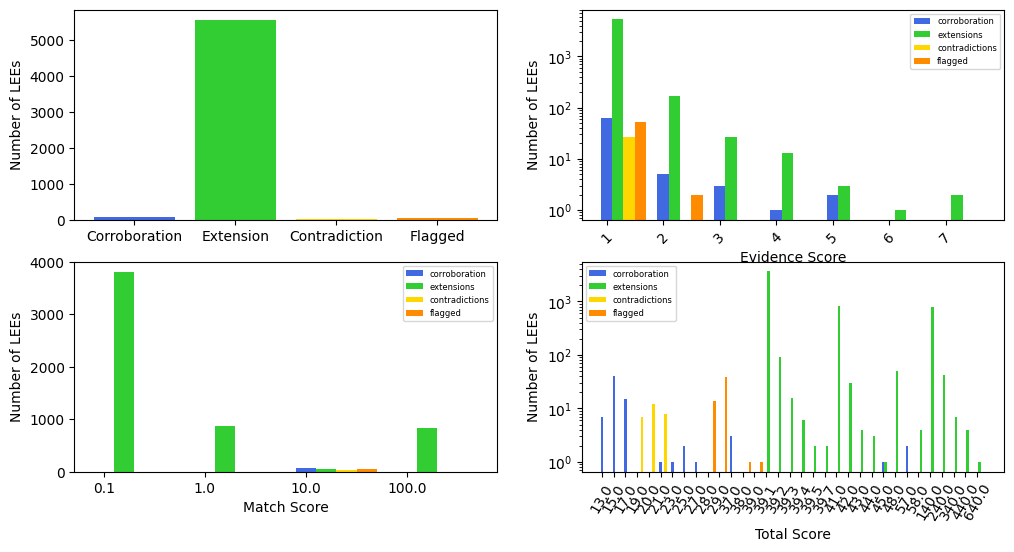

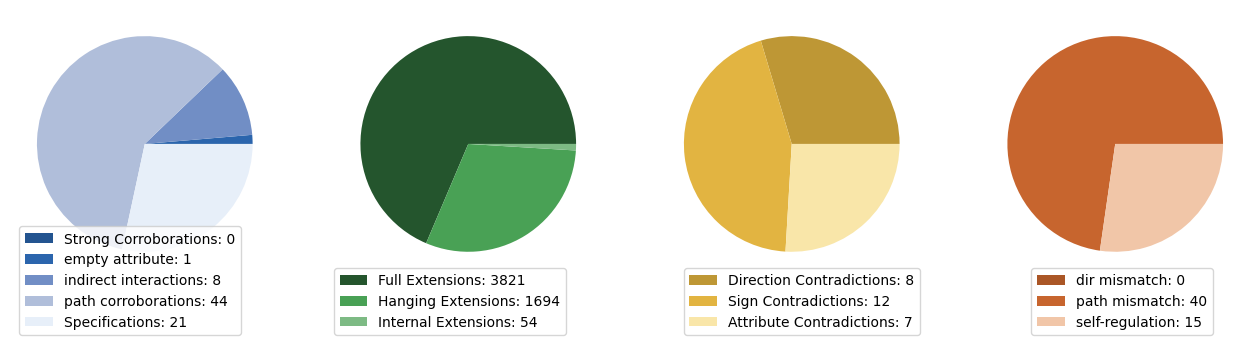

In [8]:
###_Visualization_###
visualize(match_dict, kind_dict, out_file+'_outputDF.csv', filter_opt='100%')